# Overfit - Generalización - Underfit

Vamos a poner los dos errores en perspectiva y mostraremos cómo pueden ayudarnos a saber si nuestro modelo generaliza, sobreajusta o subajusta.

In [ ]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100

In [ ]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

# Overfitting vs. underfitting
Para comprender mejor el rendimiento de generalización de nuestro modelo y tal vez encontrar información sobre cómo mejorarlo, compararemos el error de prueba con el error de entrenamiento.

In [ ]:
# Por lo tanto, necesitamos calcular el error en el conjunto de entrenamiento, con la función cross_validate.

import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results = cross_validate(regressor, data, target,
                            cv=cv, scoring="neg_mean_absolute_error",
                            return_train_score=True, n_jobs=2)
cv_results = pd.DataFrame(cv_results)
cv_results

In [5]:
# La validación cruzada utiliza el error absoluto medio negativo.
# Transformamos el error en  positivo.

scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[
    ["train_score", "test_score"]]

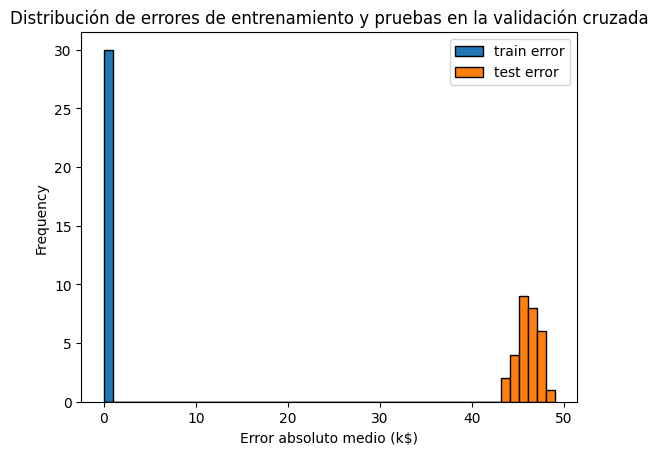

In [6]:
import matplotlib.pyplot as plt

scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Error absoluto medio (k$)")
_ = plt.title("Distribución de errores de entrenamiento y pruebas en la validación cruzada")

Al graficar la distribución de los errores de entrenamiento y prueba, obtenemos información sobre si nuestro modelo está sobreajustando, subajustando (o ambos al mismo tiempo).

Aquí, observamos un **error de entrenamiento pequeño (cero)**, lo que significa que el modelo **no está subajustando**: 
- es lo suficientemente flexible como para capturar cualquier variación presente en el conjunto de entrenamiento.

Sin embargo, el **error de prueba significativamente grande** nos dice que el modelo está **sobre-ajustando**:
- el modelo ha memorizado muchas variaciones del set de entrenamiento que podrían considerarse "ruidosos" porque no generalizan para ayudarnos a hacer una buena predicción en el conjunto de pruebas.

# Curva de validación

Algunos hiperparámetros de modelo suelen ser la clave para pasar de un modelo que subajusta a un modelo que se sobreajusta, con suerte atravesar una región en la que podemos obtener un buen equilibrio entre los dos. 

Podemos verlo trazando una **curva de validación**.

- Esta curva también se puede aplicar al experimento anterior y varía el valor de un hiperparámetro.

In [7]:
%%time

# Para el árbol de decisión, el parámetro max_depth se utiliza para controlar la compensación entre subajuste y el sobreajuste.

from sklearn.model_selection import validation_curve

max_depth = [1, 5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(
    regressor, data, target, param_name="max_depth", param_range=max_depth,
    cv=cv, scoring="neg_mean_absolute_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

CPU times: total: 750 ms
Wall time: 29.1 s


Text(0.5, 1.0, 'Curva de validación para el árbol de decisión')

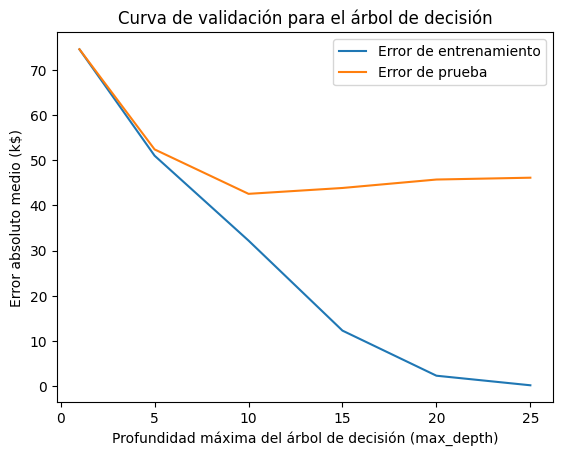

In [8]:
# trazamos los errores de entrenamiento y prueba (así como sus desviaciones).

plt.plot(max_depth, train_errors.mean(axis=1), label="Error de entrenamiento")
plt.plot(max_depth, test_errors.mean(axis=1), label="Error de prueba")
plt.legend()

plt.xlabel("Profundidad máxima del árbol de decisión (max_depth)")
plt.ylabel("Error absoluto medio (k$)")
plt.title("Curva de validación para el árbol de decisión")

La curva de validación se puede dividir en tres áreas:

- Para **max_depth < 10**, el árbol de decisión subajusta. 
    - El error de entrenamiento y, por lo tanto, el error de prueba es alto.
    - El modelo está demasiado limitado y no puede capturar gran parte de la variabilidad de la variable objetivo.
- La región **alrededor de max_depth = 10** corresponde al parámetro para el cual el árbol de decisión **mejor ajusta**.
    - Es lo suficientemente flexible como para capturar una fracción de la variabilidad del objetivo que se generaliza, sin memorizar todo el ruido en el objetivo.
- Para **max_depth > 10**, el árbol de decisión sobreajusta.
    - El error de entrenamiento se vuelve muy pequeño, mientras que el error de prueba aumenta.En esta región, los modelos crean decisiones específicamente para muestras ruidosas que dañan su capacidad para generalizar para probar los datos.

Tener en cuenta que para **max_depth = 10**, el modelo sobreajusta un poco, ya que hay una brecha entre el error de entrenamiento y el error de prueba.

También puede potencialmente subajustar un poco al mismo tiempo, porque el error de entrenamiento aún está lejos de ser cero (más de 30 k$)
- lo que significa que el modelo aún podría estar demasiado limitado para modelar partes interesantes de los datos.

<br>
    
    
Sin embargo, **el error de prueba  es mínimo, y esto es lo que realmente importa**.
- Este es el mejor compromiso que podríamos alcanzar simplemente ajustando este parámetro.

<br>

> Asimismo, tener en cuenta que mirar los errores medios es bastante limitante. Debemos analizar la **desviación estándar** para evaluar la dispersión de la puntuación.

Text(0.5, 1.0, 'Curva de validación para el árbol de decisión')

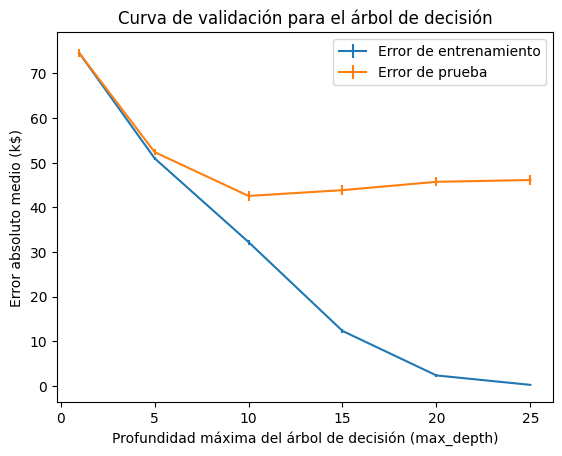

In [9]:
# Podemos repetir la misma gráfica, pero esta vez, añadiendo información para mostrar la desviación estándar de los errores.
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html

plt.errorbar(max_depth, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label='Error de entrenamiento')
plt.errorbar(max_depth, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label='Error de prueba')
plt.legend()

plt.xlabel("Profundidad máxima del árbol de decisión (max_depth)")
plt.ylabel("Error absoluto medio (k$)")
plt.title("Curva de validación para el árbol de decisión")

> **Saber más**: https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

## **Ejercicio**

Para el dataset "house-prices/full.csv" y usando Ridge: 

- Haz una evaluación de overfitting-underfitting